In [1]:
import warnings

In [2]:
import tensorflow as tf

import os
import pathlib
import time
import datetime

from matplotlib import pyplot as plt
from IPython import display

In [3]:
#Mounting Drive
from google.colab import drive
drive.mount('/content/drive')

#Imports

import matplotlib.pyplot as plt
from PIL import Image as im
from skimage.color import rgb2gray
import cv2 as cv

from google.colab import files
import os
import math
import random

import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Activation,Dropout,Flatten
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K


Mounted at /content/drive


In [4]:
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img
import os
from skimage import io
import scipy.ndimage as ndi
import scipy.signal as sig
from skimage import measure as sk
import glob
import datetime
import multiprocessing

from skimage import data
from skimage.color import rgb2gray

In [5]:
#Defining Parameters for Image Conversion
scale = 9 #Scales the radii of the diffraction profiles (large scale increases space between 'rings')
resolution = 128 #Determines image resolution
noise_level = 0.2

size_img = 128

radius_scale = 1

In [6]:
#Open and processes data in all files in a given directory
#Returns one list of radii and another of intensities


def retrieve_data(directory="/content/drive/MyDrive/AI for UED/Bismuth Profiles",uiso_lower_bound = 0.01, uiso_increment=0.1,uiso_upper_bound=1,intensity_scale=1):

  #Creating an array of file names for all Bi files
  files_to_open = []
  uiso_vals_in_range = np.arange(uiso_lower_bound,uiso_upper_bound,uiso_increment)
  uiso_vals_in_range = [round(elem, 5) for elem in uiso_vals_in_range ]

  #Opening files and processing data into lists of radii and intensities

  radii = []
  intensities = []
  uiso_labels = []
  print("----RETRIEVING DATA----")
  for subdirectories, directories, files in os.walk(directory):
    index = 0
    denom = len(uiso_vals_in_range)
    for file_name in files:

      if '(1)' not in file_name.split("reciprocal_")[1].split(".txt")[0]:
        uiso_val = float(file_name.split("reciprocal_")[1].split(".txt")[0])

        if uiso_val in uiso_vals_in_range:
          file = open(subdirectories + os.path.sep + file_name, "r")
          array_vals = []

          percent_val = round(100*index/denom,0)
          index+=1
          if percent_val%20 == 0:
            print(str(percent_val)+"%")
          for line in file:
            data_point = line.split() #X and Y values are separated by a space
            array_vals.append([scale*math.tan(math.radians(float(data_point[0]))/2),intensity_scale*float(data_point[1])]) #converts angles into radii
          radius,intensity = zip(*array_vals) #Unzipping array of [x_values,y_values] into list of x_values and y_values
          radii.append(radius)
          intensities.append(intensity)
          uiso_labels.append(uiso_val)
  print("----DONE----")
  for i in range(0,len(radii)):
    plt.plot(radii[i],intensities[i])
  plt.show()
  plt.clf()
  print("Have {} datapoints for training".format(len(radii)))


  return uiso_labels, radii, intensities

def add_multiplicative_noise(input_img):
  noise = 1+(noise_level*np.random.randn(resolution,resolution))
  noisy_img = input_img*noise
  return noisy_img


In [7]:
#Converts Radii-Intensity data into Diffraction Patterns
#Returns 2D array in which each element is: [diffraction pattern, label]

def generate_diffraction_patterns(uiso_labels,radii,intensities,one_hot_vecs,invert=False,num_augmentations=2,num_img_to_generate=7,deblurring=False,transform_image=True,sub=False,get_sub=False):

  #This code generates a two-part circular mask
  #This mask obscures all points greater than a distance of 'curr_rad' and less than a distance of 'prev_rad'
  #This creates a circle, the radius of which depends on the resolution of the angle data
  #This mask is applied to a white image in order to generate a fully white circle
  #source: https://stackoverflow.com/questions/44865023/how-can-i-create-a-circular-mask-for-a-numpy-array
  #Added an invert option because it looks cool

  images = [] #images will be a list of [diffraction patterns, labels]

  #Setting up a (resolution,resolution) sized array for the mask
  #Ogrid is used to setup a row and column vector of values ranging from 0 to resolution

  Y,X = np.ogrid[:resolution,:resolution]
  centre_val = resolution/2

  #The values stored in each vector are squared and the vectors are added (using broadcasting)
  #The value at each point of the resulting array is the 'distance' between that point and the centre
  dist_from_center = np.sqrt((X-centre_val)**2+(Y-centre_val)**2)

  #white image used to generate white circles
  #array_ones = np.ones((resolution,resolution))

  datagen = ImageDataGenerator(
    #zoom_range = 0.1,
    #rotation_range=180,
    horizontal_flip=True,
    vertical_flip=True,
    )
  print("----GENERATING DIFFRACTION PATTERNS----")
  for i in range(0,len(radii)): #iterates through all diffraction profiles
    percent_val = round(100*i/len(radii),0)
    if percent_val%20 == 0:
      print(str(percent_val)+"%")
    #creates a 'base image' for the background of the image

    base_img = np.zeros((resolution,resolution))
    uiso_label = uiso_labels[i]
    radius = radii[i]
    intensity = intensities[i]



    #Scaling the radii of each diffraction pattern
    #This ensures that the smallest radii rings (the brightest rings) have a radius equal to 8.5% of the image's width/height
    min_rad = radius[0]
    radius_adjustment_value = radius_scale*(resolution/2)*0.1735/min_rad

    prev_rad = radius[0]*radius_adjustment_value
    max_intensity = max(intensity)
    for j in range(0,len(radius)):
      curr_rad = radius[j]*radius_adjustment_value
      if curr_rad > 45:
        break

      #Defining the two-part mask
      mask = (dist_from_center <= curr_rad) & (dist_from_center > prev_rad)
      white_image = np.ones((resolution,resolution)) #np.copy(array_ones)

      #applies mask to white image
      white_image[~mask]=0

      #normalizing by setting uiso_0 images equal to OFF images in lab data
      base_img += white_image*intensity[j]
      prev_rad = curr_rad

    base_img = base_img*8000/90247000
    max_image_brightness = max(np.ndarray.flatten(base_img))

    # Setting up stopper + bright spot
    X_centered = X - resolution/2
    Y_centered = Y - resolution/2

    #making x/y square arrays
    lin_combination_image = Y_centered+X_centered

    X_square = lin_combination_image-Y_centered
    Y_square = X_centered-lin_combination_image

    #determining distance of each point in array from centre (this will be used in bright spot's the mask)
    dist_from_center = (np.sqrt((X-centre_val)**2+(Y-centre_val)**2))

    max_dist = max(np.ndarray.flatten(dist_from_center))

    #normalizes distance values
    normalized_bright_spot = (max_dist-dist_from_center)/max_dist

    #defines mask for the bright spot in the middle (with a dark spot because of the stopper)
    bright_spot_mask = (normalized_bright_spot>0.955) & (normalized_bright_spot<0.97)

    #applies mask
    normalized_bright_spot[~bright_spot_mask] = 0

    #Brightens spot based on rest of image
    normalized_bright_spot *= max_image_brightness

    #Defining mask for stopper's wire

    lin_eq_square =Y_square + 4*X_square #Defines the stopper wire's equation as b = Y + 4*X , with b ranging from +-0.04*resolution in order to give the wire some thickness
    quadrant_mask = (X_square>0) #Only want the stopper's wire in the 4th quadrant, so we limit X > 0
    wire_mask = (lin_eq_square<resolution*0.04) & (lin_eq_square>-resolution*0.04)



    #applies both masks to white image to create image of stopper

    #Subtracts image of stopper from the base image, and adds the bright spot in the middle

    mean = resolution/2
    div_param = 1
    mult_param = 82500
    exp_param = 2

    stdev = 0.35*resolution
    gaussian_base = 15000*np.exp((-(X-mean)**(2)-(Y-mean)**2)/(stdev)**2)
    dist_from_center = np.sqrt((X-resolution/2)**2+(Y-resolution/2)**2)
    mask = (dist_from_center > 13)
    gaussian_base[~mask]=0

    base_img_unadjusted = base_img

    base_img = base_img + gaussian_base

    max_image_brightness = max(np.ndarray.flatten(base_img))
    white_image = max_image_brightness*np.ones((resolution,resolution))
    white_image[~wire_mask]=0
    white_image[~quadrant_mask]=0
    base_img = np.clip(base_img - white_image ,0,max_image_brightness)
    base_img_unadjusted = np.clip(base_img_unadjusted - white_image ,0,max_image_brightness)
    if get_sub:
      return [base_img_unadjusted,uiso_label]
    if sub==True:
      base_img_unadjusted = base_img_unadjusted - sub_img_X

    max_translation = int(0.1*resolution)
    if (not transform_image):
      max_translation = 0
    for augmentation in range(0,num_augmentations):


      for q in range(0,num_img_to_generate):
        M = np.float32([
        [1, 0, random.randint(-max_translation,max_translation)],
        [0, 1, random.randint(-max_translation,max_translation)]
        ])
        new_image = cv.warpAffine(base_img, M, (resolution,resolution))
        new_image_unadjusted = cv.warpAffine(base_img_unadjusted, M, (resolution,resolution))

        blurry_img_expanded=np.expand_dims(np.expand_dims(new_image,-1),0)
        blurry_img_expanded_unadjusted=np.expand_dims(np.expand_dims(new_image_unadjusted,-1),0)


        num_images_generated = 0

        if deblurring:
          reshaped_augmented_image = np.reshape(blurry_img_expanded,(resolution,resolution))
          reshaped_augmented_image_blurry = cv.GaussianBlur(reshaped_augmented_image,(5,5),0.3+random.uniform(-0.3, 0.3))
          reshaped_augmented_image_unadjusted = np.reshape(blurry_img_expanded_unadjusted,(resolution,resolution))


          #normalizing by max
          reshaped_augmented_image_unadjusted_normalized = reshaped_augmented_image_unadjusted/np.max(reshaped_augmented_image_unadjusted)
          reshaped_augmented_image_blurry_normalized = reshaped_augmented_image_blurry/np.max(reshaped_augmented_image_blurry)


          if invert:
                max_blurry_image_brightness = max(np.ndarray.flatten(reshaped_augmented_image_blurry))
                max_blurry_image_brightness_unadjusted = max(np.ndarray.flatten(reshaped_augmented_image_unadjusted))
                inverted_image = max_blurry_image_brightness - reshaped_augmented_image_blurry
                inverted_image_unadjusted = max_blurry_image_brightness_unadjusted - reshaped_augmented_image_blurry_unadjusted

                images.append(([inverted_image,inverted_image],uiso_label))#round(float(i/(len(radii)-1)),2)])
          else:
                images.append(([np.expand_dims(reshaped_augmented_image_unadjusted_normalized,-1),
                                 np.expand_dims(reshaped_augmented_image_blurry_normalized,-1)],uiso_label))#round(float(i/(len(radii)-1)),2)])
        else:
          for augmented_image in datagen.flow(blurry_img_expanded):

            if num_images_generated < num_img_to_generate:
              num_images_generated+=1
              reshaped_augmented_image = np.reshape(augmented_image,(resolution,resolution))

              reshaped_augmented_image_blurry = cv.GaussianBlur(reshaped_augmented_image,(5,5),0.3+random.uniform(-0.3, 0.3))
              reshaped_augmented_image_unadjusted = np.reshape(blurry_img_expanded_unadjusted,(resolution,resolution))


              if invert:
                max_blurry_image_brightness = max(np.ndarray.flatten(reshaped_augmented_image_blurry))
                inverted_image = max_blurry_image_brightness - reshaped_augmented_image_blurry

                images.append((np.expand_dims(inverted_image_unadjusted,-1),uiso_label))#round(float(i/(len(radii)-1)),2)])
              else:
                  #images.append((np.expand_dims(2*(reshaped_augmented_image/np.max(reshaped_augmented_image)-0.5),-1),uiso_label))#round(float(i/(len(radii)-1)),2)])
                  images.append((reshaped_augmented_image_unadjusted,uiso_label))#round(float(i/(len(radii)-1)),2)])

            else:
              break
  print("----DONE----")
  return images

----RETRIEVING DATA----
0.0%
----DONE----


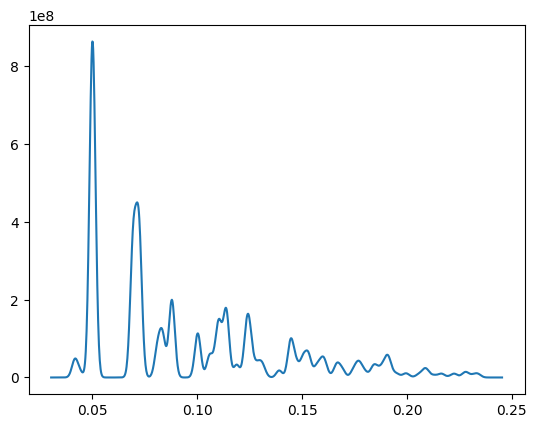

Have 1 datapoints for training
----GENERATING DIFFRACTION PATTERNS----
0.0%
----DONE----
(1, 128, 128, 1)


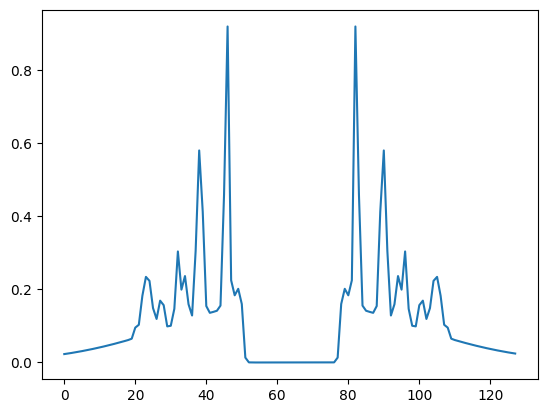

In [8]:
uiso_labels, radii, intensities = retrieve_data(uiso_lower_bound = 0.0138
                                                , uiso_increment= 0.001#<- just for placeholder #0.0002#uiso_increment=0.0005
                                                ,uiso_upper_bound=0.014#uiso_upper_bound=0.1259#0.05
                                                ,intensity_scale=10)



images_uiso = generate_diffraction_patterns(uiso_labels,radii,intensities,False,num_augmentations=1,num_img_to_generate=1,deblurring=True,transform_image=False,sub=False)

images,uiso_labels = zip(*images_uiso)

X,Y_off = zip(*images)
print(np.shape(X))
plt.plot(Y_off[0][64,0:,:])
plt.show()

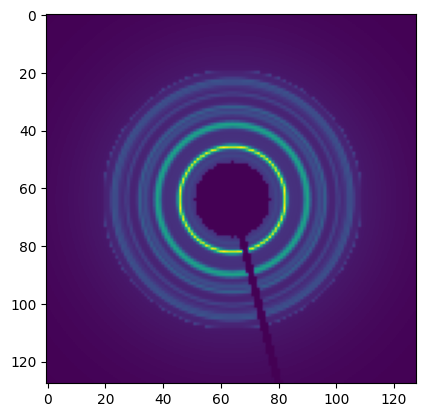

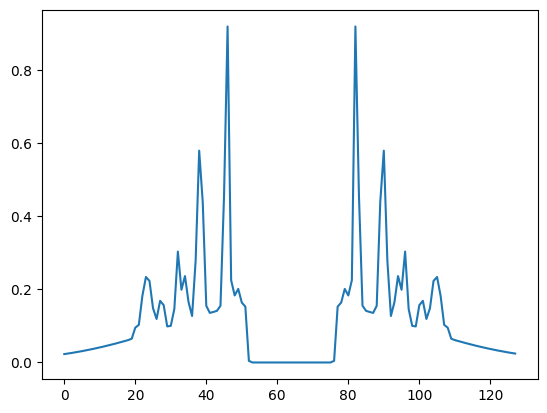

In [9]:
plt.imshow(Y_off[0][:,:,0])
plt.show()
plt.plot(Y_off[0][65,:,0])
plt.show()

----RETRIEVING DATA----
0.0%
20.0%
20.0%
40.0%
40.0%
60.0%
60.0%
80.0%
80.0%
----DONE----


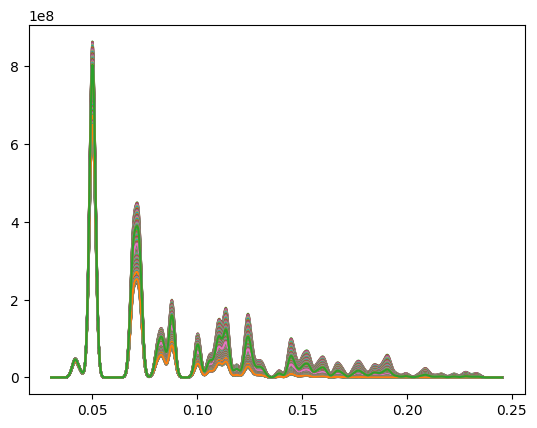

Have 173 datapoints for training


<Figure size 640x480 with 0 Axes>

In [10]:
uiso_labels, radii, intensities = retrieve_data(uiso_lower_bound = 0.0138
                                                , uiso_increment= 0.0005#0.0005#<- just for placeholder #0.0002#uiso_increment=0.0005
                                                ,uiso_upper_bound=0.1#0.5#uiso_upper_bound=0.1259#0.05
                                                ,intensity_scale=10)

In [11]:
images_uiso = generate_diffraction_patterns(uiso_labels,radii,intensities,False,num_img_to_generate=6,deblurring=True,sub=False,transform_image=False)

images_uiso.sort(key=lambda a: a[1])

images,uiso_labels = zip(*images_uiso)

X,Y = zip(*images)
synth_arr = np.array(Y)
print(len(X))

----GENERATING DIFFRACTION PATTERNS----
0.0%
20.0%
20.0%
40.0%
40.0%
60.0%
60.0%
80.0%
80.0%
----DONE----
2076


In [12]:
"""
Open npy files with lab data


"""

transform = False

data_dir = "/content/drive/MyDrive/new_centered_uiso_labelled_images/"#"/content/drive/MyDrive/uiso_labelled_images/"#"/content/drive/MyDrive/nodifference_low_fluence/nodifference_low_fluence/"#"/content/drive/MyDrive/uiso_labelled_images/"#"/content/drive/MyDrive/differenced1/"#"/content/drive/MyDrive/uiso_labelled_images/" #"/content/drive/MyDrive/differenced_centered/differenced_centered/"#"/content/drive/MyDrive/differenced_labelled_actual/" #

uiso_vals = []
lab_images = []


#size_img = 128

Y_grid,X_grid = np.ogrid[:size_img,:size_img]
#dist_from_center = np.sqrt((X_grid-65)**2+(Y_grid-69)**2)
dist_from_center = np.sqrt((X_grid-64)**2+(Y_grid-64)**2)
mask = (dist_from_center > 13)

i= 0

for file in os.scandir(data_dir):
    if (file.path.split(data_dir)[1].split(".npy")[0] != 'labels'):

      #print(float(file.path.split("/content/drive/MyDrive/uiso_labelled_images/")[1].split(".npy")[0]))
      img = np.load(file.path,allow_pickle=True)
      image_arr_cropped = img[:,74:-74]


      image_from_array = Image.fromarray(image_arr_cropped)
      image_resized = np.array(image_from_array.resize((128,128))).astype("float32")

      """
      max_val = np.max(np.abs(image_resized))#,-np.min(image_resized))
      #print(max_val)
      if max_val == 0:
        continue
      for row_idx in range(size_img):
        for col_idx in range(size_img):
          image_resized[row_idx][col_idx] = image_resized[row_idx][col_idx]/max_val
      """





      image_resized[~mask] = 0


      #image_resized_normalized = (image_resized-np.mean(image_resized))/(np.max(image_resized) - np.min(image_resized))#(image_resized/np.max(image_resized)-0.5)*2
      #image_resized_normalized = image_resized_normalized - min(np.min(image_resized_normalized),0)

      image_resized_normalized = image_resized/np.max(image_resized)    # (image_resized/np.max(image_resized)-0.5)*2#image_resized/max(np.max(image_resized),-np.min(image_resized))#((image_resized)/(np.max(image_resized))-0.5)*2
      #

      if(transform):
        for augmentation in range(0,1):
          max_translation = 0#int(0.1*resolution)
          #for q in range(0,3):
          for q in range(0,7):
            M = np.float32([
            [1, 0, random.randint(-max_translation,max_translation)],
            [0, 1, random.randint(-max_translation,max_translation)]
            ])
            new_image = cv.warpAffine(image_resized_normalized, M, (resolution,resolution))
            #new_image[~mask] = 0

            #blurry_img_expanded=np.expand_dims(np.expand_dims(new_image,-1),0)

            #lab_images.append(blurry_img_expanded)
            lab_images.append(new_image)
            uiso_vals.append(float(file.path.split(data_dir)[1].split(".npy")[0]))
      else:

        lab_images.append(np.expand_dims(image_resized_normalized,-1))
        uiso_vals.append(float(file.path.split(data_dir)[1].split(".npy")[0]))




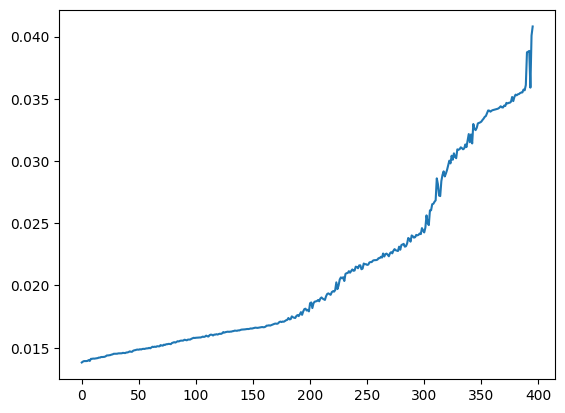

In [13]:
plt.plot(uiso_vals)

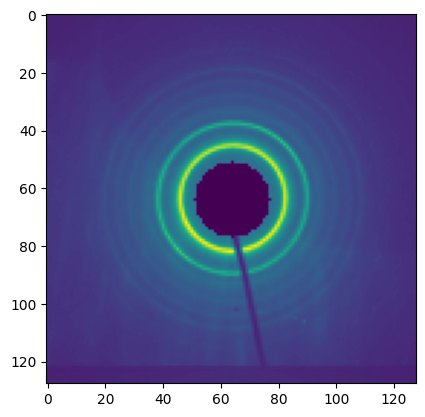

In [14]:
plt.imshow(lab_images[1][:,:,0])
plt.show()


In [15]:
lab_img_arr = np.array(lab_images)
lab_img_arr=lab_img_arr/np.max(lab_img_arr)

In [16]:
synthetic_image_dict = {}

for idx in range(len(uiso_labels)):
  synthetic_image_dict[uiso_labels[idx]] = Y[idx]

In [17]:
labimgs_with_uiso = list(zip(uiso_vals,lab_images))
labimgs_with_uiso.sort(key=lambda a: a[0])
sorted_lab_uiso,sorted_labimgs = zip(*labimgs_with_uiso)
sorted_labimgs = np.expand_dims(sorted_labimgs,-1)

In [18]:
lab_to_sim_mapping_uiso = {}

In [19]:
vals_to_avoid = []

for idx in range(len(sorted_lab_uiso)):
  lab_uiso = sorted_lab_uiso[idx]

  best_gap = 1000
  best_idx = None
  for idx2 in range(len(uiso_labels)):
    if np.abs(uiso_labels[idx2]-lab_uiso) < best_gap:# and uiso_labels[idx2] not in vals_to_avoid:
      best_gap = np.abs(uiso_labels[idx2]-lab_uiso)
      best_idx = idx2
  if best_idx == None:
    lab_to_sim_mapping_uiso[lab_uiso] = None
    print(idx)
  else:
    lab_to_sim_mapping_uiso[lab_uiso] = uiso_labels[best_idx]
    vals_to_avoid.append(uiso_labels[best_idx])

In [20]:
triple_list = []

for idx in range(len(sorted_lab_uiso)):
  lab_uiso = sorted_lab_uiso[idx]
  cm_uiso = lab_to_sim_mapping_uiso[lab_uiso]
  lab_image = sorted_labimgs[idx][:,:,:,0]
  cm_image = synthetic_image_dict[cm_uiso]
  triple_list.append([lab_image,cm_image,lab_uiso])
random.shuffle(triple_list)
labimgs_list_for_training,cm_list_for_training,uiso_list_for_training = zip(*triple_list)


In [21]:
def gen_shuffled_data():

  train_test_ratio = 0.9
  assert(len(cm_list_for_training) == len(labimgs_list_for_training))

  #-------------
  #X/Y were switched here.
  Y_train, Y_test = cm_list_for_training[0:int(train_test_ratio*len(cm_list_for_training))],cm_list_for_training[int(train_test_ratio*len(cm_list_for_training)):]
  X_train, X_test = labimgs_list_for_training[0:int(train_test_ratio*len(cm_list_for_training))],labimgs_list_for_training[int(train_test_ratio*len(cm_list_for_training)):]
  labels_train, labels_test = np.array(uiso_list_for_training[0:int(train_test_ratio*len(cm_list_for_training))]),np.array(uiso_list_for_training[int(train_test_ratio*len(cm_list_for_training)):])
  #-------------

  """
  plt.plot(labels_train)
  plt.title("shuffled train set")
  plt.show()
  plt.plot(labels_test)
  plt.title("shuffled test set")
  plt.show()
  """



  list_to_sort_train = list(zip(X_train,Y_train,labels_train))
  list_to_sort_test = list(zip(X_test,Y_test,labels_test))

  list_to_sort_train.sort(key=lambda a: a[2])
  list_to_sort_test.sort(key=lambda a: a[2])

  X_train,Y_train,labels_train = zip(*list_to_sort_train)
  X_test,Y_test,labels_test = zip(*list_to_sort_test)

  """
  plt.plot(labels_train)
  plt.title("sorted train set")
  plt.show()
  plt.plot(labels_test)
  plt.title("sorted test set")
  plt.show()
  """
  X_train_np_array = np.array(X_train).astype(np.float32)#[:,:,:,0]
  #print("max in x train: ",np.max(X_train_np_array))
  #print("min in x train: ",np.min(X_train_np_array))

  Y_train_np_array = np.array(Y_train).astype(np.float32)
  #print("max in y train: ",np.max(Y_train_np_array))
  #print("min in y train: ",np.min(Y_train_np_array))

  X_test_np_array = np.array(X_test).astype(np.float32)#[:,:,:,0]
  X_test_np_array = X_test_np_array


  Y_test_np_array = np.array(Y_test).astype(np.float32)
  Y_test_np_array = Y_test_np_array

  labels_train_np_array = np.expand_dims(np.array(labels_train).astype(np.float32),axis=-1)
  labels_test_np_array = np.expand_dims(np.array(labels_test).astype(np.float32),axis=-1)

  print(Y_train_np_array.shape)
  print(X_train_np_array.shape)

  if X_train_np_array.shape != Y_train_np_array.shape:
    raise Exception("Array shapes don't match")

  train_dataset_GAN_2 = tf.data.Dataset.from_tensor_slices((X_train_np_array, Y_train_np_array,labels_train_np_array))
  test_dataset_GAN_2 = tf.data.Dataset.from_tensor_slices((X_test_np_array, Y_test_np_array,labels_test_np_array))


  train_dataset_GAN_2 = train_dataset_GAN_2.batch(34)#, drop_remainder=True)
  test_dataset_GAN_2 = test_dataset_GAN_2.batch(34)#, drop_remainder=True)
  #print(train_dataset_GAN_2)
  #print(test_dataset_GAN_2)

  return train_dataset_GAN_2,test_dataset_GAN_2


In [22]:
def scatter_plot(arr,color_str='blue',title=None):
  plt.scatter(x = range(len(arr)),y=arr,color=color_str)
  if title is not None:
    plt.title(title)
  plt.show()
  plt.clf()


In [23]:
def error_calcs(pred_cm,pred_gen,verbose=False,return_avg=False):
  error_vals = []
  num_sub_50 = 0
  num_sub_10 = 0
  num_sub_5 = 0
  for idx in range(len(pred_cm)):
    pred_val_cm = pred_cm[idx]
    pred_val_lab = pred_gen[idx]
    error = 100*(pred_val_cm-pred_val_lab)/pred_val_cm
    if abs(error) < 50:
      num_sub_50+=1
      if abs(error) < 10:
        num_sub_10+=1
        if abs(error) < 5:
          num_sub_5+=1

    error_vals.append(error)
  avg_val = sum(np.abs(error_vals))/len(error_vals)
  if verbose:
    scatter_plot(error_vals,title="error vals")
    print("average percent error: ",avg_val)
    print("within 50% of ground truth: ",num_sub_50/len(error_vals))
    print("within 10% of ground truth: ",num_sub_10/len(error_vals))
    print("within 5% of ground truth: ",num_sub_5/len(error_vals))

  if return_avg:
    return ([num_sub_10,num_sub_5],avg_val)
  else:
    return (num_sub_10,num_sub_5)

In [24]:
#Defining neural net

def build_cnn_model():
  cnn_model = keras.Sequential([
      keras.layers.Conv2D(filters=18,kernel_size=(5,5),activation=tf.nn.relu),
      keras.layers.MaxPool2D(pool_size=(2, 2)),

      keras.layers.Conv2D(filters=36,kernel_size=(5,5),activation=tf.nn.relu),
      keras.layers.MaxPool2D(pool_size=(2, 2)),

      keras.layers.Conv2D(filters=72,kernel_size=(3,3),activation=tf.nn.relu),
      keras.layers.MaxPool2D(pool_size=(2, 2)),

      keras.layers.Conv2D(filters=144,kernel_size=(2,2),activation=tf.nn.relu),
      keras.layers.MaxPool2D(pool_size=(2, 2)),

      keras.layers.Flatten(),
      keras.layers.Dense(256, activation=tf.nn.relu),
      keras.layers.Dense(128, activation=tf.nn.relu),
      #keras.layers.Dropout(0.6),
      keras.layers.Dense(1)#, activation=tf.nn.softmax)
  ])

  return cnn_model

def compile_cnn(model,init_lr=0.001):
  initial_learning_rate = init_lr
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
      initial_learning_rate,
      decay_steps=300,
      decay_rate=0.96,
      staircase=True)
  model.compile(loss = 'mean_squared_error', optimizer = tf.keras.optimizers.RMSprop(learning_rate = lr_schedule),
                  metrics = [linear_regression_equality])
  return model

"""
These metrics check the accuracy of the network.
The second metric (which has a larger allowed error) determines whether the network's prediction is 'in the ballpark'
"""
accepted_diff = 0.002
#error_accepted = 0.1
def linear_regression_equality(y_true, y_pred):
    diff = K.abs(y_true-y_pred)
    return K.mean(K.cast(diff < accepted_diff, tf.float32))


In [25]:
def train(model,X_array,Y_array, EPOCHS=15):

  accuracy_values = []
  validation_accuracy_values= []
  loss_values = []
  validation_loss_values = []

  for epoch in range(0,EPOCHS):#epoch_to_load+EPOCHS+1):

    print("-------------STARTING EPOCH {}-------------".format(epoch+1))
    history = model.fit(X_array,Y_array,batch_size=30,epochs=10,validation_split=0.1,verbose=0)
    #Storing accuracy and loss values
    accuracy_values.append(history.history['linear_regression_equality'][0])
    validation_accuracy_values.append(history.history['val_linear_regression_equality'][0])
    loss_values.append(history.history['loss'][0])
    validation_loss_values.append(history.history['val_loss'][0])

  f1 = plt.figure()
  f2 = plt.figure()
  ax1 = f1.add_subplot(111)

  ax1.plot(accuracy_values, "-b",label = "train accuracy")
  ax1.plot(validation_accuracy_values, "-r",label = "test accuracy")
  ax1.legend()
  ax2 = f2.add_subplot(111)
  ax2.plot(loss_values, "-b",label = "train loss")
  ax2.plot(validation_loss_values, "-r",label = "test loss")
  ax2.set_ylim([0,validation_loss_values[1]])
  ax2.legend()
  plt.show()

----RETRIEVING DATA----
0.0%
0.0%
0.0%
0.0%
0.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
----DONE----


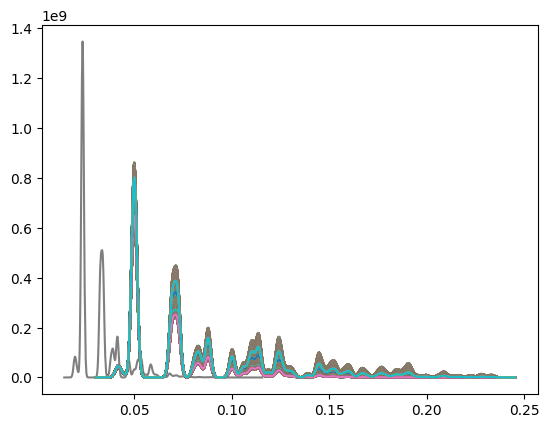

Have 860 datapoints for training
----GENERATING DIFFRACTION PATTERNS----
0.0%
0.0%
0.0%
0.0%
0.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
100.0%
100.0%
100.0%
100.0%
----DONE----


<Figure size 640x480 with 0 Axes>

In [26]:
#generating CM data for CNN training

uiso_labels_, radii_, intensities_ = retrieve_data(uiso_lower_bound = 0.01
                                                , uiso_increment= 0.0001
                                                ,uiso_upper_bound=0.1
                                                ,intensity_scale=10)

images_uiso = generate_diffraction_patterns(uiso_labels_,radii_,intensities_,False,num_img_to_generate=4,deblurring=True,sub=False,transform_image=True)

random.shuffle(images_uiso)
images_,uiso_labels_ = zip(*images_uiso)

X_,Y_ = zip(*images_)

Y_ = np.array(Y_)
Y_ = Y_/np.max(Y_)
uiso_labels_np_arr_ = np.array(uiso_labels_)


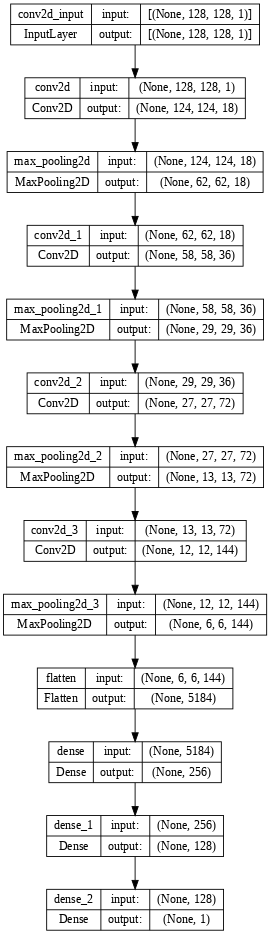

In [27]:
model = compile_cnn(build_cnn_model(),0.001)
model.build(input_shape=(None,128,128,1))
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

-------------STARTING EPOCH 1-------------
-------------STARTING EPOCH 2-------------


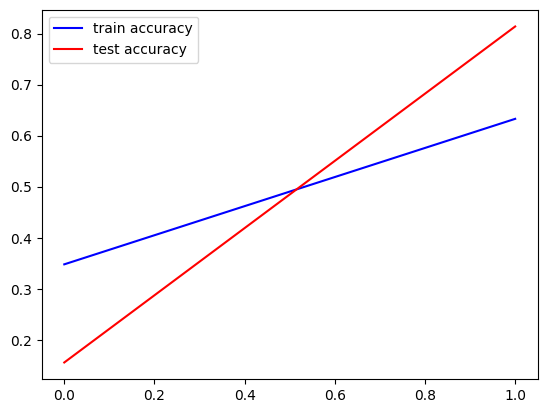

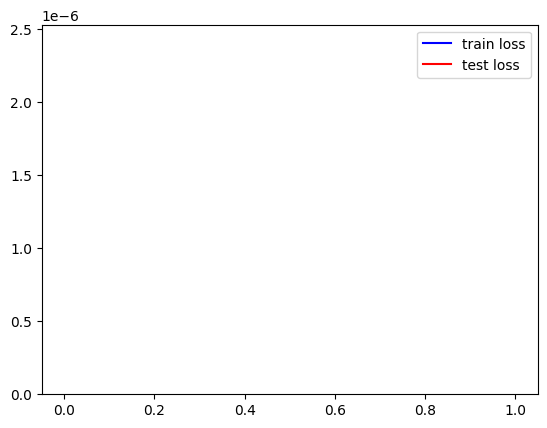

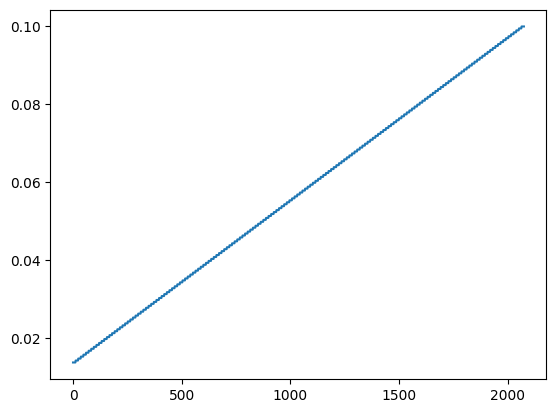

65/65 [==============================] - 0s 3ms/step


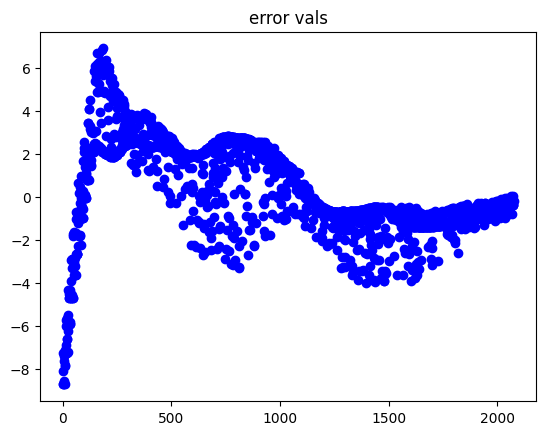

average percent error:  [1.7004797]
within 50% of ground truth:  1.0
within 10% of ground truth:  1.0
within 5% of ground truth:  0.970616570327553


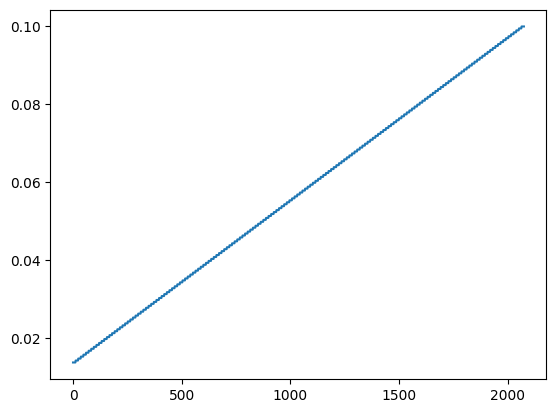

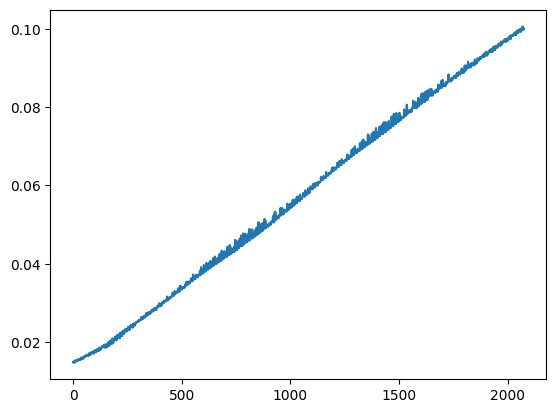

In [29]:
train(model,np.array(Y_),np.array(uiso_labels_np_arr_),EPOCHS=11)
plt.plot(uiso_labels)
plt.show()
preds = model.predict(synth_arr)

error_calcs(uiso_labels,preds,verbose=True)
plt.plot(uiso_labels)
plt.show()
plt.plot(preds)
plt.show()


-------------STARTING EPOCH 1-------------
-------------STARTING EPOCH 2-------------


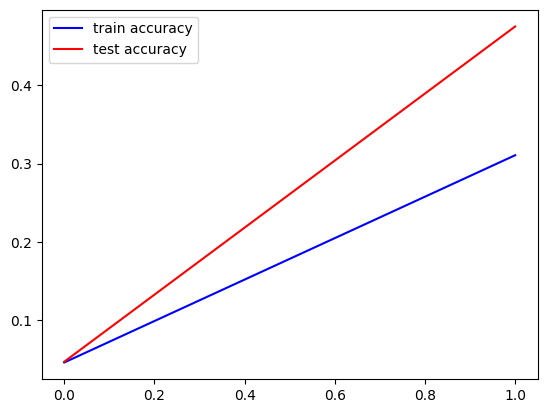

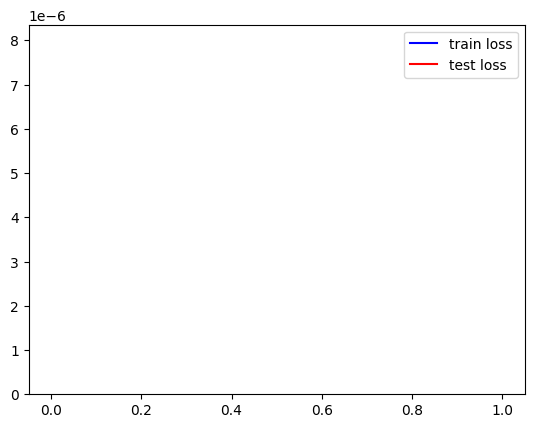

should see perfect alignment


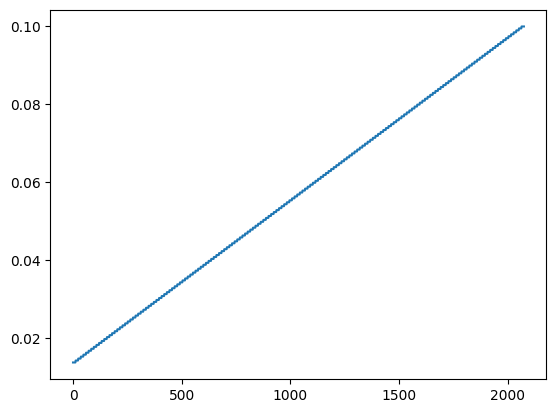

65/65 [==============================] - 0s 3ms/step


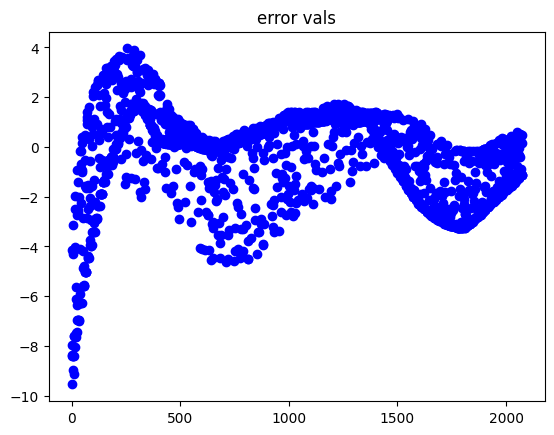

average percent error:  [1.3916065]
within 50% of ground truth:  1.0
within 10% of ground truth:  1.0
within 5% of ground truth:  0.9807321772639692


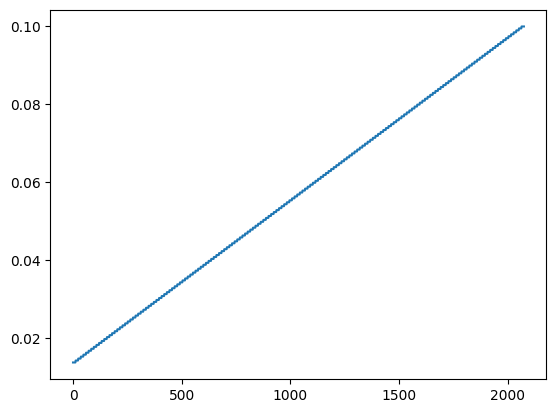

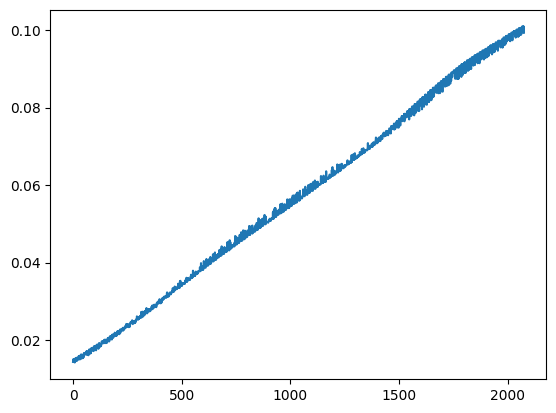

In [30]:
model_2 = compile_cnn(build_cnn_model(),0.001)
model_2.build(input_shape=(None,128,128,1))

tf.keras.utils.plot_model(model_2, show_shapes=True, dpi=64)

for reps in range(1):

  train(model_2,np.array(Y_),np.array(uiso_labels_np_arr_),EPOCHS=11)
  print("should see perfect alignment")
  plt.plot(uiso_labels)
  plt.show()
  preds = model_2.predict(synth_arr)

  error_calcs(uiso_labels,preds,verbose=True)
  plt.plot(uiso_labels)
  plt.show()
  plt.plot(preds)
  plt.show()

In [31]:
cnn_model = model_2

In [32]:
#from: https://www.tensorflow.org/tutorials/generative/pix2pix

In [33]:
OUTPUT_CHANNELS = 1

In [34]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [35]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [36]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[128, 128,1])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    #downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    #upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation=tf.nn.relu)#'sigmoid')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

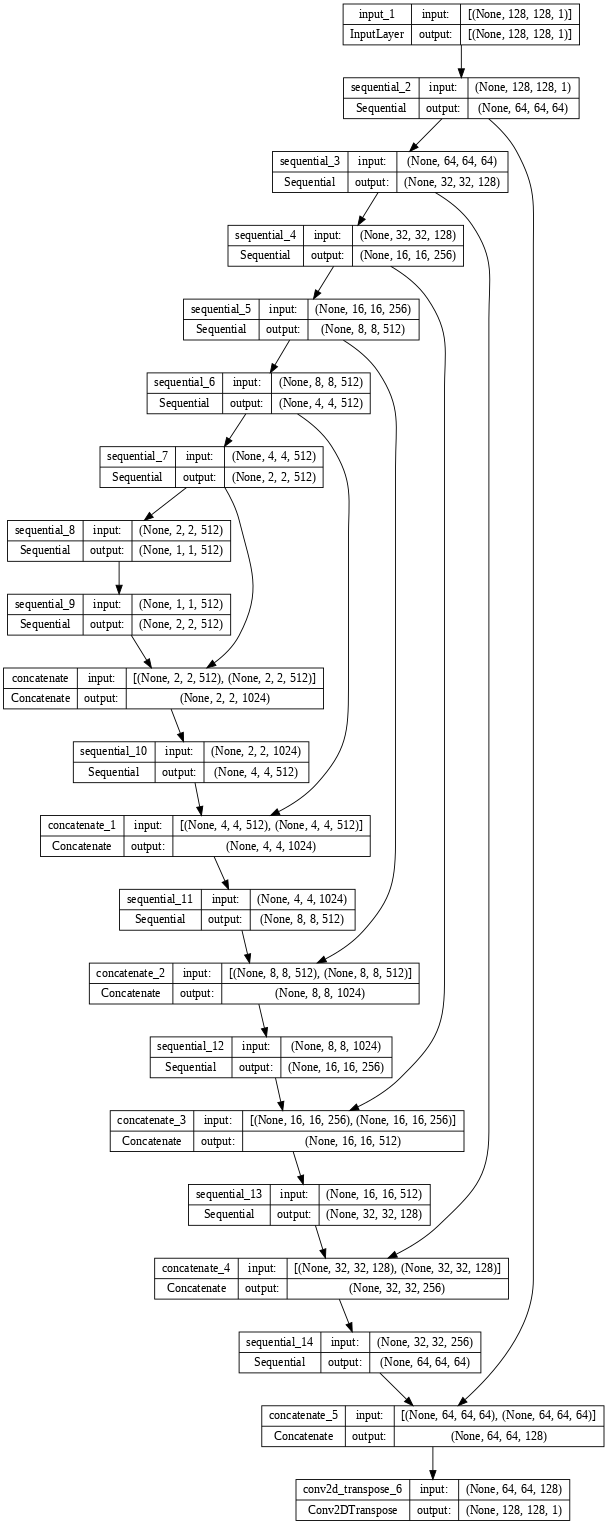

In [37]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

In [38]:
#1,inf for same img

In [39]:
#.3, 15 for diff imgs

In [40]:
import tensorflow as tf
import os
import cv2
import numpy as np
from tensorflow.keras.losses import MSE
from skimage.filters import gaussian
import random
#from config import *


SSIM_FACTOR = -15.0#15.0#20.0
PSNR_FACTOR = -7.0
ADVERSARIAL_LOSS_FACTOR = 1.0
SP_LOSS_FACTOR = 1.1*0.5
PIXEL_LOSS_FACTOR = 0.01


def batch_ssim_psnr_sum(batch_truth, batch_fake):
    ssim = tf.reduce_mean(tf.image.ssim(batch_truth, batch_fake, 1.0))
    ssim = tf.multiply(ssim, SSIM_FACTOR)
    psnr = tf.reduce_mean(tf.image.psnr(batch_truth, batch_fake, 1.0))
    psnr = tf.multiply(psnr, PSNR_FACTOR)
    return tf.add(ssim, psnr)


def batch_ssim_psnr_show(batch_truth, batch_fake):
    ssim = tf.reduce_mean(tf.image.ssim(batch_truth, batch_fake, 1.0))
    psnr = tf.reduce_mean(tf.image.psnr(batch_truth, batch_fake, 1.0))
    return ssim, psnr

In [41]:
LAMBDA = 100
#CNN_loss_coeff = 900
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(disc_generated_output, gen_output, target,uiso_val,use_CNN,CNN_loss_coeff):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)


  l2_loss = tf.reduce_mean(tf.math.squared_difference(target, gen_output))



  SPLOSS = tf.abs(tf.multiply(batch_ssim_psnr_sum(target, gen_output), SP_LOSS_FACTOR))

  CNN_uiso_error = tf.reduce_mean(tf.math.abs(tf.math.subtract(cnn_model(gen_output), uiso_val)))


  if not use_CNN:
    total_gen_loss = gan_loss + (LAMBDA * l2_loss) + SPLOSS/5
  else:

    total_gen_loss = gan_loss + (LAMBDA * l2_loss) + CNN_loss_coeff*CNN_uiso_error + SPLOSS/5

  return total_gen_loss, gan_loss, LAMBDA * l2_loss,CNN_loss_coeff*CNN_uiso_error,SPLOSS/5




In [42]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[128, 128, 1], name='input_image')
  tar = tf.keras.layers.Input(shape=[128, 128, 1], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

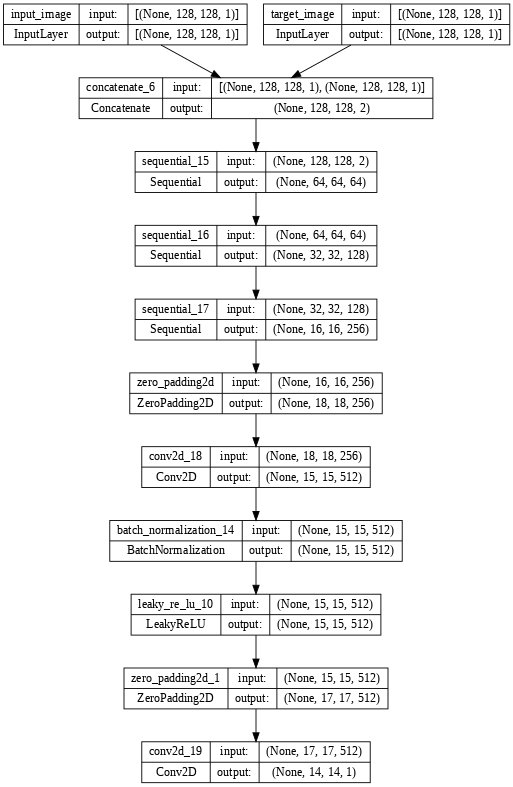

In [43]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

In [44]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [45]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [46]:
def generate_images(model, test_input, tar=None,gen_only=False,num=3):
  if gen_only:
    prediction = model(test_input, training=True)
    return prediction
  else:
    prediction = model(test_input, training=True)
    for j in range(num):
      plt.figure(figsize=(15, 15))
      idx = np.random.randint(0,np.shape(test_input)[0])
      mse_loss_1 = tf.reduce_mean(tf.abs(tar[idx] - prediction[idx]))
      print("\nMSE between gen output and target: {}".format(mse_loss_1))

      mse_loss_2 = tf.reduce_mean(tf.abs(tar[idx] - test_input[idx]))
      print("MSE between gen output and input: {}".format(mse_loss_2))

      mse_loss_3 = tf.reduce_mean(tf.abs(test_input[idx] - prediction[idx]))
      print("MSE between input and target: {}".format(mse_loss_3))

      display_list = [test_input[idx,:,:,0], tar[idx,:,:,0], prediction[idx][:,:,0]]
      title = ['Input Image', 'Ground Truth', 'Predicted Image']
      print("Max: {}".format(np.max(prediction[idx])))
      print("Min: {}".format(np.min(prediction[idx])))
      for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # Getting the pixel values in the [0, 1] range to plot.
        plt.imshow(display_list[i],cmap='gray')
        plt.axis('off')
      plt.show()



In [47]:
generator = Generator()
discriminator = Discriminator()
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [48]:
folder_name = "good_cnn"
checkpoint_dir = "/content/drive/MyDrive/AI for UED/GAN Weights/Pix2Pix Checkpoints/"+folder_name+"/"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

log_dir="/content/drive/MyDrive/AI for UED/GAN Weights/Pix2Pix Checkpoints/"+folder_name+"/logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [49]:
dict_errors = {}

CNN_parameters = []

SP_parameters = []


num_ = 5
for CNN_param_iter in [120]:
  for SSIM_param in [-15]:
    for PSNR_param in [-2.5]:
      CNN_parameters = []
      SP_parameters = []

      for experiment in range(1):
        num_+=1

        CNN_param = CNN_param_iter
        CNN_loss_coeff_val = CNN_param

        print("CNN: ",CNN_param_iter)
        print("experiment: ", experiment)

        CNN_parameters.append(CNN_param_iter)
        SP_parameters.append([SSIM_param,PSNR_param,SP_LOSS_FACTOR])

        @tf.function
        def train_step(input_image, target, uiso_val, step,use_CNN,CNN_loss_coeff):
          with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            gen_output = generator(input_image, training=True)

            disc_real_output = discriminator([input_image, target], training=True)

            disc_generated_output = discriminator([input_image, gen_output], training=True)

            gen_total_loss, gen_gan_loss, gen_l1_loss,gen_CNN_LOSS,SP_Loss = generator_loss(disc_generated_output, gen_output, target,uiso_val,use_CNN,CNN_loss_coeff)
            disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

          generator_gradients = gen_tape.gradient(gen_total_loss,
                                                  generator.trainable_variables)
          discriminator_gradients = disc_tape.gradient(disc_loss,
                                                      discriminator.trainable_variables)

          generator_optimizer.apply_gradients(zip(generator_gradients,
                                                  generator.trainable_variables))
          discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                                      discriminator.trainable_variables))

          with summary_writer.as_default():
            tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
            tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
            tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
            tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

          return (gen_total_loss,gen_gan_loss, gen_l1_loss,disc_loss,gen_CNN_LOSS,SP_Loss)


        def fit(train_ds, test_ds, steps,use_CNN,CNN_loss_coeff):
          gen_total_loss_list,gen_gan_loss_list, gen_l1_loss_list,disc_loss_list,CNN_uiso_loss_list, SP_Loss_list = [],[],[],[],[],[]

          example_input, example_target,example_uiso_val = next(iter(test_ds.take(1)))
          step_ctr =0
          for step, (input_image, target,uiso_val) in train_ds.repeat().take(steps).enumerate():
            step_ctr+=1
            (gen_total_loss,gen_gan_loss, gen_l1_loss,disc_loss,CNN_uiso_loss,SP_Loss) = train_step(input_image, target,uiso_val , step,use_CNN,CNN_loss_coeff)
            gen_total_loss_list.append(gen_total_loss.numpy())
            gen_gan_loss_list.append(gen_gan_loss.numpy())
            gen_l1_loss_list.append(gen_l1_loss.numpy())
            disc_loss_list.append(disc_loss.numpy())
            CNN_uiso_loss_list.append(CNN_uiso_loss.numpy())
            SP_Loss_list.append(SP_Loss.numpy())

            # Save (checkpoint) the model every 5k steps
            if (step + 1) % 10000 == 0:
              print("saved")
              checkpoint.save(file_prefix=checkpoint_prefix)



          return sum(gen_total_loss_list)/step_ctr,sum(gen_gan_loss_list)/step_ctr, sum(gen_l1_loss_list)/step_ctr,sum(disc_loss_list)/step_ctr,sum(CNN_uiso_loss_list)/step_ctr, sum(SP_Loss_list)/step_ctr

        def gen_img_for_Training(model, test_input,uiso_labels,example_uiso):
          prediction = model(test_input, training=True)

          output_arr = []
          for idx in range(0,np.shape(prediction)[0]):

            output_arr.append([uiso_labels[idx],prediction[idx],example_uiso[idx]])
          return output_arr

        def create_gen_set(generator,uiso_dataset,num=3):
          list_gen_output = []
          if num == 3:
            for example_input, example_target, example_uiso in uiso_dataset.as_numpy_iterator():#uiso_dataset.take(3):

              list_gen_output += gen_img_for_Training(generator, example_input,example_target,example_uiso)

            return list_gen_output
          else:
            for example_input, example_uiso in uiso_dataset.as_numpy_iterator():#uiso_dataset.take(3):

              list_gen_output += gen_img_for_Training(generator, example_input,example_uiso)

            return list_gen_output


        train_stats = []
        test_stats = []

        train_stats_ALC = []
        test_stats_ALC = []


        avg_train_error = []
        avg_test_error = []

        avg_train_error_ALC = []
        avg_test_error_ALC = []


        num_iter = 21
        print("starting")
        gen_total_loss_list,gen_gan_loss_list, gen_l1_loss_list,disc_loss_list,CNN_uiso_loss_list, SP_Loss_list = [],[],[],[],[],[]
        start_with_cnn = True
        iter_boost_cnn = 5*60

        train_dataset_GAN_2,test_dataset_GAN_2 = gen_shuffled_data()



        for idx_ in range(num_iter):
          if idx_ == iter_boost_cnn:
              CNN_loss_coeff_val = CNN_loss_coeff_val*2
          if (idx_) % 10 == 0 or num_iter == 1:
            print("")
            print("epoch: ", idx_+1)

          print('.', end='', flush=True)
          if idx_ < 25 and not start_with_cnn:

            gen_total_loss,gen_gan_loss, gen_l1_loss,disc_loss,CNN_uiso_loss,SP_Loss = fit(train_dataset_GAN_2, test_dataset_GAN_2, steps=367,use_CNN=False,CNN_loss_coeff=CNN_loss_coeff_val)#10000#60000)
          else:

            gen_total_loss,gen_gan_loss, gen_l1_loss,disc_loss,CNN_uiso_loss,SP_Loss = fit(train_dataset_GAN_2, test_dataset_GAN_2, steps=367,use_CNN=True,CNN_loss_coeff=CNN_loss_coeff_val)#10000#60000)


          gen_total_loss_list.append(gen_total_loss)
          gen_gan_loss_list.append(gen_gan_loss)
          gen_l1_loss_list.append(gen_l1_loss)
          disc_loss_list.append(disc_loss)
          CNN_uiso_loss_list.append(CNN_uiso_loss)
          SP_Loss_list.append(SP_Loss)

          lab_gen = create_gen_set(generator,train_dataset_GAN_2,num=3)

          cm_imgs = []
          lab_imgs_gen = []
          for idx in range(len(lab_gen)):
            lab_imgs_gen.append(lab_gen[idx][1])
            cm_imgs.append(lab_gen[idx][0])
          lab_imgs_gen_arr = np.array(lab_imgs_gen)
          cm_imgs_arr = np.array(cm_imgs)

          pred_gen = model.predict(lab_imgs_gen_arr)
          pred_cm = model.predict(cm_imgs_arr)

          pred_gen_ALC = cnn_model.predict(lab_imgs_gen_arr)
          pred_cm_ALC = cnn_model.predict(cm_imgs_arr)


          #TEST performance
          lab_gen_test = create_gen_set(generator,test_dataset_GAN_2,num=3)
          cm_imgs_test = []
          lab_imgs_gen_test = []

          for idx in range(len(lab_gen_test)):
            lab_imgs_gen_test.append(lab_gen_test[idx][1])
            cm_imgs_test.append(lab_gen_test[idx][0])

          lab_imgs_gen_arr_test = np.array(lab_imgs_gen_test)
          cm_imgs_arr_test = np.array(cm_imgs_test)

          pred_gen_test = model.predict(lab_imgs_gen_arr_test)
          pred_cm_test = model.predict(cm_imgs_arr_test)

          pred_gen_ALC_test = cnn_model.predict(lab_imgs_gen_arr_test)
          pred_cm_ALC_test = cnn_model.predict(cm_imgs_arr_test)

          if (idx_+1) % 3 == 0 or num_iter == 1:
            plt.imshow(lab_imgs_gen_arr[0,:,:,0])
            plt.show()
            print("TRAIN PERFORMANCE: ")
            plt.plot(labels_train)
            plt.title("true uiso vals, no cnn")
            plt.show()
            scatter_plot(pred_gen,title="cnn predicted uiso for generated images")
            scatter_plot(pred_cm,title="cnn predicted uiso for lab images")

            print("train perf")
            train_perf = error_calcs(labels_train,pred_gen,verbose=True,return_avg=True)
            print("non analytic")
            train_perf_ = error_calcs(pred_cm,pred_gen,verbose=True,return_avg=True)


            print("train perf ALC")
            train_perf_ALC = error_calcs(labels_train,pred_gen_ALC,verbose=True,return_avg=True)

            train_stats.append(train_perf[0])
            train_stats_ALC.append(train_perf_ALC[0])


            avg_train_error_ALC.append(train_perf_ALC[1][0])
            avg_train_error.append(train_perf[1][0])

            scatter_plot(avg_train_error,title="% error on training set")
            scatter_plot(avg_train_error_ALC,title="% error on training set ALC")

            print("TEST PERFORMANCE: ")
            plt.plot(labels_test)
            plt.title("true uiso vals, no cnn (test)")
            plt.show()
            scatter_plot(pred_gen_test,title="cnn predicted uiso for generated images (test)")
            scatter_plot(pred_cm_test,title="cnn predicted uiso for lab images (test)")


            x_test = list(range(len(pred_gen_test)))

            print("analytic")
            plt.scatter(x_test,labels_test)
            plt.scatter(x_test,pred_gen_test)
            plt.show()
            print("cnn output for cm and gen")
            plt.scatter(x_test,pred_cm_test)
            plt.scatter(x_test,pred_gen_test)
            plt.show()

            x_train = list(range(len(pred_gen)))

            print("analytic")
            plt.scatter(x_train,labels_train)
            plt.scatter(x_train,pred_gen)
            plt.show()
            print("cnn output for cm and gen")
            plt.scatter(x_train,pred_cm)
            plt.scatter(x_train,pred_gen)
            plt.show()



            print("test perf")
            test_perf = error_calcs(labels_test,pred_gen_test,verbose=True,return_avg=True)
            print("non analytic")
            train_perf_ = error_calcs(pred_cm_test,pred_gen_test,verbose=True,return_avg=True)
            print("test perf ALC")
            test_perf_ALC = error_calcs(labels_test,pred_gen_ALC_test,verbose=True,return_avg=True)

            test_stats.append(test_perf[0])
            test_stats_ALC.append(test_perf_ALC[0])

            avg_test_error.append(test_perf[1][0])
            avg_test_error_ALC.append(test_perf_ALC[1][0])

            scatter_plot(avg_test_error,title="% error on test set")
            scatter_plot(avg_test_error_ALC,title="% error on test set ALC")

          else:
            train_perf = error_calcs(labels_train,pred_gen,verbose=False,return_avg=True)
            train_perf_ALC = error_calcs(labels_train,pred_gen_ALC,verbose=False,return_avg=True)

            test_perf = error_calcs(labels_test,pred_gen_test,verbose=False,return_avg=True)
            test_perf_ALC = error_calcs(labels_test,pred_gen_ALC_test,verbose=False,return_avg=True)

            train_stats.append(train_perf[0])
            test_stats.append(test_perf[0])

            train_stats_ALC.append(train_perf_ALC[0])
            test_stats_ALC.append(test_perf_ALC[0])


            avg_train_error.append(train_perf[1][0])
            avg_test_error.append(test_perf[1][0])

            avg_train_error_ALC.append(train_perf_ALC[1][0])
            avg_test_error_ALC.append(test_perf_ALC[1][0])

            if (idx_+1) % 10 == 0:
              print(" ")
              print("train error: ",train_perf[1][0])
              print("test error: ",test_perf[1][0])


        plt.imshow(lab_imgs_gen_arr[0,:,:,0])
        plt.show()

        under_10,under_5 = zip(*train_stats)
        scatter_plot(under_10,title="num within 10% error")
        scatter_plot(under_5,title="num within 5% error")

        under_10,under_5 = zip(*train_stats_ALC)
        scatter_plot(under_10,title="num within 10% error ALC")
        scatter_plot(under_5,title="num within 5% error ALC")



        fig, ax = plt.subplots()
        ax.plot(avg_train_error,color = "red",label="Training Error")
        ax.plot(avg_test_error, color = "blue",label="Test Error")
        ax.set_xlabel("Number of Epochs", fontsize= 10)
        ax.set_ylabel("Percent Error",fontsize= 10)
        ax.legend(prop={'size': 12})
        plt.show()
        title = "graph_without_title_" + str(num_) +".eps"
        fig.savefig(title,format='eps',dpi=200)



        scatter_plot(avg_test_error,title="% error on test set")
        print("")
        under_10,under_5 = zip(*test_stats)
        scatter_plot(under_10,title="num within 10% error (test)")
        scatter_plot(under_5,title="num within 5% error (test)")

        under_10,under_5 = zip(*test_stats_ALC)
        scatter_plot(under_10,title="num within 10% error (test) ALC")
        scatter_plot(under_5,title="num within 5% error (test) ALC")

        dict_errors[experiment] = (avg_train_error_ALC,avg_test_error_ALC)
        print("train:")
        print(avg_train_error)
        print("test:")
        print(avg_test_error)
        print("train alc:")
        print(avg_train_error_ALC)
        print("test alc:")
        print(avg_test_error_ALC)

      print("-----")

      overall_avg_test = []
      for experiment in dict_errors.keys():
        print("experiment: ",experiment)
        print("CNN param: ", str(CNN_parameters[experiment]))
        print("SP params: ", str(SP_parameters[experiment]))

        err_lists_tuple = dict_errors[experiment]

        train_list = err_lists_tuple[0]
        test_list = err_lists_tuple[1]

        sub_5_ctr = 0
        min_train = min(train_list)
        epoch_min_train = train_list.index(min_train)

        for i in range(len(train_list)):
          val = train_list[i]
          if val < 5:
            sub_5_ctr+=1
          if sub_5_ctr == 4:
            print("choosing fourth sub 5 val")
            epoch_min_train =  i
            break

        test_at_min_train = test_list[epoch_min_train]

        min_test = min(test_list)
        epoch_min_test = test_list.index(min_test)
        train_at_min_test = train_list[epoch_min_test]

        print("min train error is: ",min_train, " at epoch: ",epoch_min_train," with test error of: ",test_at_min_train)
        print("min test error is: ",min_test, " at epoch: ", epoch_min_test, " with train error of: ",train_at_min_test)
        avg_test_error = sum(test_list)/len(test_list)
        overall_avg_test.append(avg_test_error)
        print("average test error is: ", avg_test_error)
        scatter_plot(train_list,title="error on training set")
        scatter_plot(test_list,title="error on test set")

      scatter_plot(overall_avg_test,title="plot of average % error on test set over experiments")

CNN:  120
experiment:  0
starting
(356, 128, 128, 1)
(356, 128, 128, 1)

epoch:  1
.

KeyboardInterrupt: ignored

In [ ]:
checkpoint.save(file_prefix=checkpoint_prefix)